# Assignment Wind and Waves

## Question 1 - FEM Model

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch
import sympy as sym
import scipy.optimize as opt
import scipy

In [2]:
# General parameters
M_RNA = 550E3           # RNA Mass [kg]
H = 105                 # Hub height [m]
h = 35                  # Water depth [m]
Omega_max = 11.3        # Max rotor speed [rpm]
F = 200E3               # Fetch [m]
U10 = 23                # Wind speed [m/s]

L = H + h               # Total length [m]
d = 7                   # Diameter [m]
t = 0.01 * d            # Thickness [m]
A = np.pi * d * t       # Cross-sectional area [m²]
rho = 7850              # Density [kg/m³]
E = 210E9               # Young's modulus [Pa]
I = np.pi*(d/2)**3*t    # Moment of inertia [m^4]

q = 20E3                  # Distributed load [kN/m]

g = 9.81                # Gravitational acceleration [m/s²]

### Step 1: discretize the domain

In [3]:
ne = 12
nn = ne + 1
ndofs = 2*nn
xn = np.linspace(0, L, nn)

l_elem = L/12

In [4]:
elem_dofs = []
dof_node = []
for ie in np.arange(0,ne):
    elem_dofs.append(np.arange(2*ie, 2*ie+4))
for idof in np.arange(0, ndofs):
    dof_node.append(int(np.floor(idof/2)))

In [5]:
# Define Cubic Shape Functions
N_k = []
dN_k = []
ddN_k = []
h_e = L/ne
matrix = np.array([[1, 0, 0, 0], [0, 1, 0, 0], [1, h_e,  h_e**2, h_e**3], [0, 1, 2*h_e, 3*h_e**2]])

def base(x):
    if isinstance(x, float):
        return np.array([[1], [x], [x**2], [x**3]])
    else:
        return np.array([[np.ones(len(x))], [x], [x**2], [x**3]])
def dbase(x):
    if isinstance(x, float):
        return np.array([[0], [1], [2*x], [3*x**2]])
    else:
        return np.array([[np.zeros(len(x))], [np.ones(len(x))], [2*x], [3*x**2]])
def ddbase(x):
    if isinstance(x, float):
        return np.array([[0], [0], [2], [6*x]])
    else:
        return np.array([[np.zeros(len(x))], [np.zeros(len(x))], [2*np.ones(len(x))], [6*x]])
    
def make_N(coeff): 
    return lambda x: np.dot(np.transpose(base(x)), coeff)
def make_dN(coeff):
    return lambda x: np.dot(np.transpose(dbase(x)), coeff)
def make_ddN(coeff):
    return lambda x: np.dot(np.transpose(ddbase(x)), coeff)

dof_vec = np.arange(0,4)
for idof in dof_vec:
    rhs = np.zeros(len(dof_vec))
    rhs[idof] = 1
    coeff = np.linalg.solve(matrix, rhs)
    N_k.append(make_N(coeff))
    dN_k.append(make_dN(coeff))
    ddN_k.append(make_ddN(coeff))

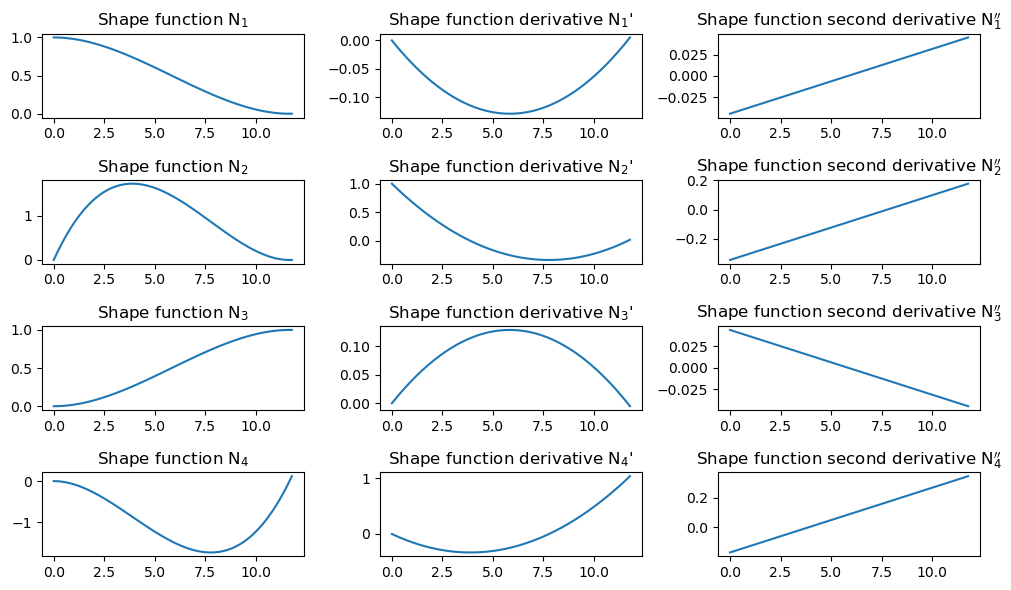

In [6]:
xplot = np.arange(0, h_e + h_e/100, h_e/100)

fig, axs = plt.subplots(4, 3, figsize=(10, 6))
axs[0, 0].plot(xplot, N_k[0](xplot))
axs[0, 0].set_title("Shape function N$_1$")
axs[0, 1].plot(xplot, dN_k[0](xplot))
axs[0, 1].set_title("Shape function derivative N$_1$'")
axs[0, 2].plot(xplot, ddN_k[0](xplot))
axs[0, 2].set_title("Shape function second derivative N$_1''$")
axs[1, 0].plot(xplot, N_k[1](xplot))
axs[1, 0].set_title("Shape function N$_2$")
axs[1, 1].plot(xplot, dN_k[1](xplot))
axs[1, 1].set_title("Shape function derivative N$_2$'")
axs[1, 2].plot(xplot, ddN_k[1](xplot))
axs[1, 2].set_title("Shape function second derivative N$_2''$")
axs[2, 0].plot(xplot, N_k[2](xplot))
axs[2, 0].set_title("Shape function N$_3$")
axs[2, 1].plot(xplot, dN_k[2](xplot))
axs[2, 1].set_title("Shape function derivative N$_3$'")
axs[2, 2].plot(xplot, ddN_k[2](xplot))
axs[2, 2].set_title("Shape function second derivative N$_3''$")
axs[3, 0].plot(xplot, N_k[3](xplot))
axs[3, 0].set_title("Shape function N$_4$")
axs[3, 1].plot(xplot, dN_k[3](xplot))
axs[3, 1].set_title("Shape function derivative N$_4$'")
axs[3, 2].plot(xplot, ddN_k[3](xplot))
axs[3, 2].set_title("Shape function second derivative N$_4''$")


# automatically fix subplot spacing
plt.tight_layout()

In [7]:
import scipy.integrate as scp
M_k = np.zeros((4, 4))
K_k = np.zeros((4, 4))
Q_k = np.zeros(4)

for idof in np.arange(0, 4):
    for jdof in np.arange(0, 4):
        def eqn_M(x):
            return rho*A*N_k[idof](x)*N_k[jdof](x)
        def eqn_K(x): 
            return E*I*ddN_k[idof](x)*ddN_k[jdof](x)
        def eqn_Q(x):
            return q*N_k[idof](x)
            
        M_k[idof, jdof] = scp.quad(eqn_M, 0, h_e)[0]
        K_k[idof, jdof] = scp.quad(eqn_K, 0, h_e)[0]
        Q_k[idof] = scp.quad(eqn_Q, 0, h_e)[0]

In [8]:
K = np.zeros((ndofs*ndofs))       # 1-D array for global stiffness matrix
M = np.zeros((ndofs*ndofs))       # 1-D array for global mass matrix
Q = np.zeros(ndofs)               # 1-D array for Q vector

for ie in np.arange(0, ne):
    # Get the nodes of the elements
    dofs = elem_dofs[ie]
    NodeLeft = dof_node[dofs[0]]
    NodeRight = dof_node[dofs[-1]]
    
    # Get the degrees of freedom that correspond to each node
    Dofs_Left = 2*(NodeLeft) + np.arange(0, 2)
    Dofs_Right = 2*(NodeRight) + np.arange(0, 2)

    # Assemble the matrices at the correct place
    nodes = np.append(Dofs_Left, Dofs_Right)
    for i in np.arange(0, 4):
        Q[nodes[i]] = Q[nodes[i]] + Q_k[i]
        for j in np.arange(0, 4):
            ij = nodes[j] + nodes[i]*ndofs
            M[ij] = M[ij] + M_k[i, j]
            K[ij] = K[ij] + K_k[i, j]
            
# Reshape the global matrix from a 1-D array to a 2-D array
M = M.reshape((ndofs, ndofs))
K = K.reshape((ndofs, ndofs))

# Add RNA mass to the last node
M[-2, -2] += M_RNA

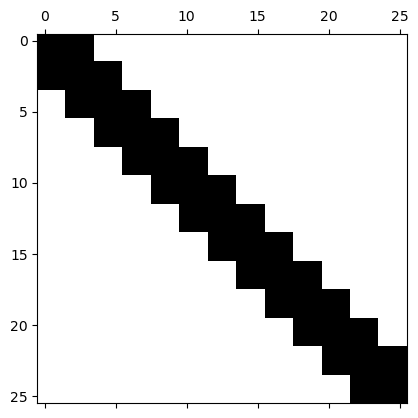

In [9]:
plt.figure()
plt.spy(M);

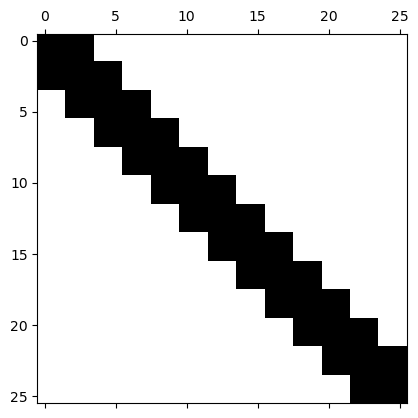

In [10]:
plt.figure()
plt.spy(K);

In [11]:
fixed_dofs = np.arange(0, 2)                    # fixed DOFs
free_dofs = np.arange(0, ndofs)                 # free DOFs
free_dofs = np.delete(free_dofs, fixed_dofs)    # remove the fixed DOFs from the free DOFs array

# free & fixed array indices
fx = free_dofs[:, np.newaxis]
fy = free_dofs[np.newaxis, :]
bx = fixed_dofs[:, np.newaxis]
by = fixed_dofs[np.newaxis, :]

# Mass
Mii = M[fx, fy]
Mib = M[fx, by]
Mbi = M[bx, fy]
Mbb = M[bx, by]

# Stiffness
Kii = K[fx, fy]
Kib = K[fx, by]
Kbi = K[bx, fy]
Kbb = K[bx, by]

Qii = Q[fy]
Qbb = Q[by]

### Step 2: Find Natural Frequencies

In [12]:
mat = np.dot(np.linalg.inv(Mii), Kii)
eigenvalues, eigenvectors = np.linalg.eig(mat)
omega_eigen = np.sort(np.sqrt(eigenvalues.real))
f_eigen = omega_eigen/2/np.pi

print("First 5 natural frequencies:")
for i in np.arange(0,5):
    print(f"Frequency {i+1}: {f_eigen[i]:.2f} Hz, {omega_eigen[i]:.2f} rad/s")
    
print()
print(f"Omega_max: {Omega_max:.2f} rpm")
print(f"Omega_max: {Omega_max/60:.2f} Hz")
print(f"Omega_max: {2*np.pi*Omega_max/60:.2f} rad/s")

First 5 natural frequencies:
Frequency 1: 0.24 Hz, 1.51 rad/s
Frequency 2: 1.81 Hz, 11.40 rad/s
Frequency 3: 5.45 Hz, 34.26 rad/s
Frequency 4: 11.11 Hz, 69.84 rad/s
Frequency 5: 18.83 Hz, 118.34 rad/s

Omega_max: 11.30 rpm
Omega_max: 0.19 Hz
Omega_max: 1.18 rad/s


In [13]:
# Rayleigh Damping
zeta1 = zeta2 = 0.02

A_mat = np.array([
    [1/(2*omega_eigen[0]), omega_eigen[0]/2],
    [1/(2*omega_eigen[1]), omega_eigen[1]/2]
])
b_vec = np.array([zeta1, zeta2])

alpha_d, beta_d = np.linalg.solve(A_mat, b_vec)
print("alpha_d = ", alpha_d)
print("beta_d = ", beta_d)
C_d = alpha_d*M + beta_d*K
Cii = C_d[np.ix_(free_dofs, free_dofs)]

alpha_d =  0.053230906104525993
beta_d =  0.0030985683377135476


### Step 3: Sanity Checks

The displacements resulting from the model are hereby compared with analytical results for a cantilever beam in order to validate the FE implementation:

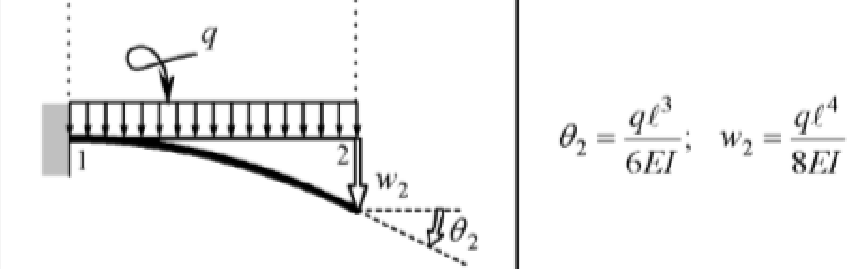


Displacement at the top of the beam: 0.49 m
Rotation at the top of the beam: 0.0046 rad

Displacement at the top of the beam (analytical): 0.49 m
Rotation at the top of the beam (analytical): 0.0046 rad


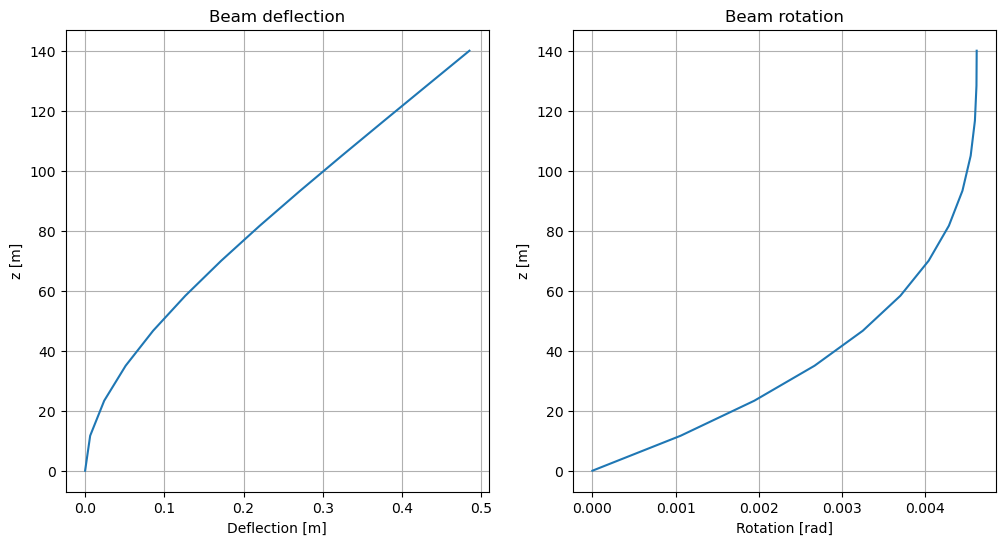

In [14]:
# Solve for displacements
u = Qii @ np.linalg.inv(Kii)

# Add fixed boundary conditions back in
u_full = np.insert(u, 0, [0,0])

# Plot results
fig, ax = plt.subplots(1,2, figsize=(12, 6))
ax[0].plot(u_full[::2], xn)
ax[0].set_ylabel('z [m]')
ax[0].set_xlabel("Deflection [m]")
ax[0].set_title("Beam deflection");
ax[0].grid()

ax[1].plot(u_full[1::2], xn)
ax[1].set_ylabel('z [m]')
ax[1].set_xlabel("Rotation [rad]")
ax[1].set_title("Beam rotation");
ax[1].grid()

print(f"Displacement at the top of the beam: {u_full[-2]:.2f} m")
print(f"Rotation at the top of the beam: {u_full[-1]:.4f} rad")

print()

u_top_analytical = q * L**4 / (8 * E * I)
phi_top_analytical = q * L**3 / (6 * E * I)

print(f"Displacement at the top of the beam (analytical): {u_top_analytical:.2f} m")
print(f"Rotation at the top of the beam (analytical): {phi_top_analytical:.4f} rad")


The deflection and rotation at the top of the beam from the model agree with the analytical expressions.

## Question 2: Monopile Diameter Tuning
In order to avoid resonances the first natural frequency of the structure must not coincide with the rotor frequency ($\Omega_{max}$). The radius of the monopile is therefore tuned to return a natural frequency approximately 10% higher than the 1P frequency ($\Omega_{max}$). 

- A $D/t$ ratio of 100 was chosen as a design parameter. (within the range of 80-120)

A diameter of 7 m was chosen which returns a first natural frequency of 0.24 Hz, which is acceptable compared to the given $\Omega_{max}$=0.19 Hz.

Acceptance criterion was a structure natural frequency at least 10% higher than the rotor frequency.
(Previous cells already include the design radius, which was determined by iteration)

## Question 3: Wind and wave co-spectra
Regarding the constants, a few assumptions were made. $u_*$ was chosen as 2.0 m, in accordance with the slides of lecture 2. A roughness length of $z_0$ = 1e-4 m was chosen, as this one is suitable for oceans (see answers to the exercises of lecture 2). Based on these answers, the constant $A$ which is multiplied with $u_*$ to obtain the standard deviation was chosen to be 3 (typically larger than 2.5 for oceans). The constants $C_y$ and $C_z$ are typically 10 (lecture 2). $C$ and $m$ were estimated based on the graph on slide 11 of that lecture, which is depending on $z_0$. For the JONSWAP spectrum, values of $\gamma$ = 3.3 and $\beta$ = 5/4 were used in accordance with lecture 1.

In [15]:
# Question 3 and 4 parameters
u_star = 2              # Friction velocity [m/s]
k = 0.40                # Von-Karman constant
z_0 = 1e-4              # Roughness length [m]
A_ = 3                   # constant for calculation of sigma_u
C_y = 10                # constant for calculation of non-dimensional cross-spectrum
C_z = 10                # constant for calculation of non-dimensional cross-spectrum
C = 500                 # belonging to z0=1e-3
m = 0.03                # belonging to z0=1e-3
gamma = 3.3             # constant for JONSWAP spectrum
beta = 5 / 4            # constant for JONSWAP spectrum

In [16]:
# SymPy code to obtain an analytical expression for the unknowns for load case 1
# F_tilde, f_p_tilde, U_10, f_p, g, F = sym.symbols('F_tilde f_p_tilde U_10 f_p g F')
# eq1 = sym.Eq(f_p_tilde, U_10 * f_p / g)
# eq2 = sym.Eq(F_tilde, g * F / U_10**2)
# eq3 = sym.Eq(f_p_tilde, 3.5 / F_tilde**0.33)
# sol = sym.solve([eq1, eq2, eq3], (U_10, F_tilde, f_p_tilde), dict=True)
# '''[{
# F_tilde: 0.000630376100157691*F*f_p**2/(g*(g**33/(F**33*f_p**66))**(1/17)),
# U_10: 39.8290667529805*g*(g**33/(F**33*f_p**66))**(1/34)/f_p,
# f_p_tilde: 39.8290667529805*(g**33/(F**33*f_p**66))**(1/34)
# }]'''

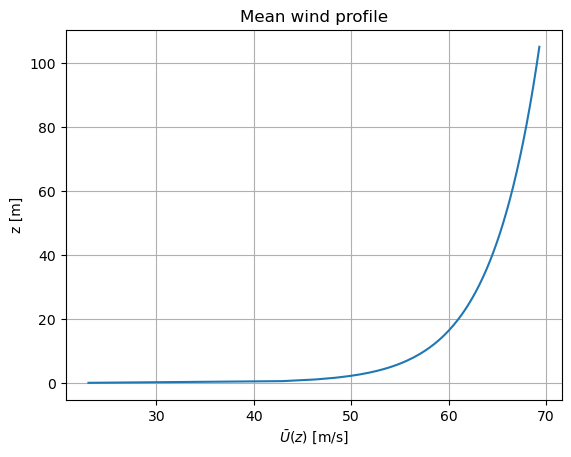

In [17]:
def U_bar(z, u_star, k=0.4, z_0=1e-4):
    return u_star / k * np.log(z / z_0)

def dispersion_eqn(k, omega, g, d): 
    return omega**2 - k * g * np.tanh(k * d)

def solve_wavenumber(omega, g, d, k_guess=1.0):
    k_solution, = opt.fsolve(dispersion_eqn, k_guess, args=(omega, g, d))
    return k_solution

z_wind = np.linspace(0.01, H, 200)
U_bar_values = U_bar(z_wind, u_star, k, z_0)
plt.plot(U_bar_values, z_wind)
plt.xlabel('$\\bar{U}(z)$ [m/s]')
plt.ylabel('z [m]')
plt.title('Mean wind profile');
plt.grid();

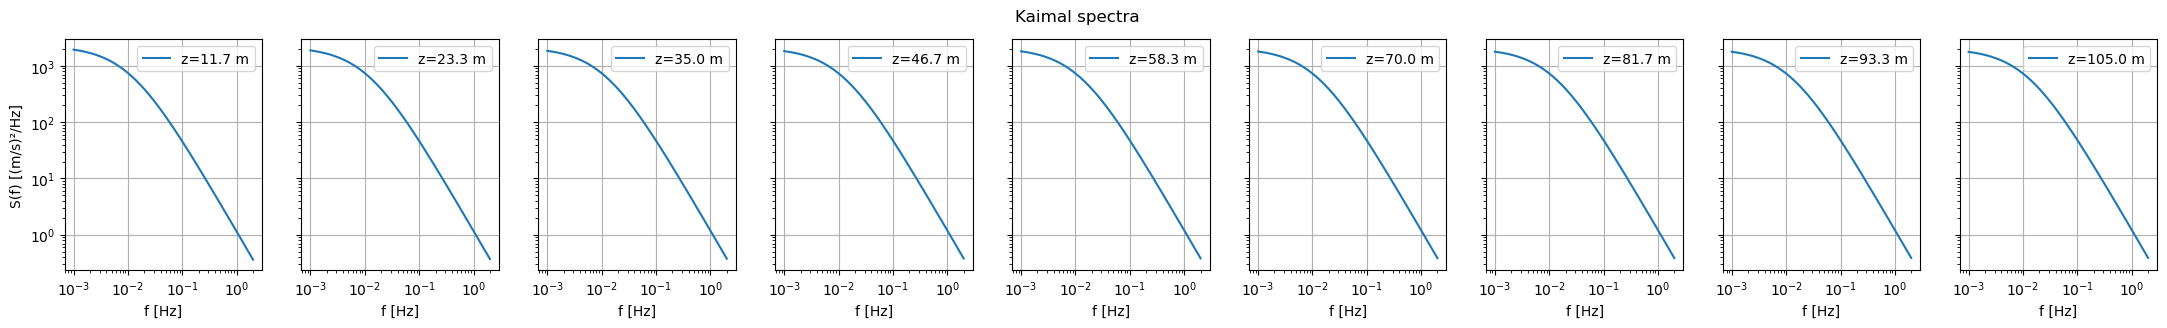

In [18]:
def L_u_x(z, C, m):
    return C * z**m

def Kaimal(z, f, C, m, u_star, k, z_0):
    f_L = f * L_u_x(z, C, m) / U_bar(z, u_star, k, z_0)
    R_N = 6.8 * f_L / (1 + 10.2 * f_L)**(5 / 3)
    return f_L, R_N

z_nodes = np.linspace(-h, H, 13)
z_nodes_air = z_nodes[z_nodes > 0]
f_kaimal = np.linspace(0.001, 2.0, 5000)
S_auto = np.zeros((len(z_nodes_air), len(f_kaimal)))
R_N_auto = np.zeros((len(z_nodes_air), len(f_kaimal)))
f_L = np.zeros(len(f_kaimal))


fig, axes = plt.subplots(1, 9, figsize=(27,3), sharex=True, sharey=True)
for i,z in enumerate(z_nodes_air):
    f_L, R_N = Kaimal(z, f_kaimal, C, m, u_star, k, z_0)

    I_u = k * A_ / np.log(z / z_0)
    sigma_u = I_u * U_bar(z, u_star, k, z_0)
    
    S_auto[i] = sigma_u**2 * R_N / f_kaimal
    R_N_auto[i] = R_N

    axes[i].loglog(f_kaimal, S_auto[i], label=f'z={z:.1f} m')
    axes[i].grid()
    axes[i].legend()
    axes[i].set_xlabel('f [Hz]')
    axes[0].set_ylabel('S(f) [-]')
    
    
axes[0].set_ylabel('S(f) [(m/s)²/Hz]')
plt.suptitle('Kaimal spectra')

def wind_cross_spectrum(f):
    S_wind_cross = np.zeros((len(z_nodes_air), len(z_nodes_air), len(f)))
    R_N_wind_cross = np.zeros((len(z_nodes_air), len(z_nodes_air), len(f)))

    for i,S_1 in enumerate(S_auto):
        for j,S_2 in enumerate(S_auto):
            if i == j:
                S_wind_cross[i, j] = S_1
                R_N_wind_cross[i, j] = 1
                continue
            z_i = z_nodes_air[i]
            z_j = z_nodes_air[j]
            r_z = np.abs(z_i - z_j)
            U_b = (U_bar(z_i, u_star, k, z_0) + U_bar(z_j, u_star, k, z_0)) / 2
            psi_u = np.exp(-f / U_b * np.sqrt((C_y * 0)**2 + (C_z * r_z)**2))
            S_cross = psi_u * np.sqrt(S_1 * S_2)
            
            S_wind_cross[i, j] = S_cross
            R_N_wind_cross[i, j] = psi_u
    return S_wind_cross, R_N_wind_cross

S_wind_cross, R_N_wind_cross = wind_cross_spectrum(f_kaimal)


# Plotting the auto- and cross-spectra (commented to save time)

# fig, axes = plt.subplots(len(z_nodes_air), len(z_nodes_air), figsize=(15, 15), sharex=True, sharey=True)

# for i in range(len(S_auto)):
#     for j in range(len(S_auto)):
#         axes[i, j].loglog(f_L, R_N_wind_cross[i, j])

# fig.supxlabel('f [Hz]')
# fig.supylabel('$\\mathrm{S_{uu}(f)}$ [-]')
# fig.suptitle('Auto- and co-spectra')
# fig.tight_layout()

The significant wave height of load case 1 is 0.602 [m].
The significant wave height of load case 2 is 6.237 [m].


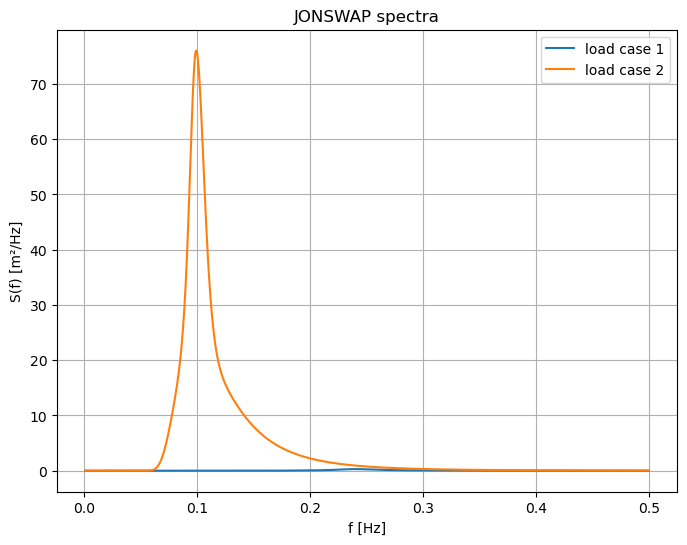

In [19]:
#Load case 1: resonance response
f_p_1 = f_eigen[0]
T_p_1 = 1 / f_p_1
U_10_1 = 39.8290667529805 * g * (g**33 / (F**33 * f_p_1**66))**(1 / 34) / f_p_1
F_tilde_1 = g * F / U_10_1**2
f_p_tilde_1 = 3.5 * F_tilde_1**(-0.33)
alpha_1 = 0.076 * F_tilde_1**(-0.22)

#Load case 2: idling in operational conditions
U_10_2 = 23 #m/s
F_tilde_2 = g * F / U_10_2**2
f_p_tilde_2 = 3.5 * F_tilde_2**(-0.33)
f_p_2 = f_p_tilde_2 * g / U_10_2
T_p_2 = 1 / f_p_2
alpha_2 = 0.076 * F_tilde_2**(-0.22)

def JONSWAP(alpha, g, f, beta, f_p, gamma):
    sigma = 0.07 * np.ones_like(f)
    sigma[f > f_p] = 0.09

    S = alpha * g**2 * (2 * np.pi)**(-4) * f**(-5) * np.exp(-beta * (f / f_p)**(-4)) * gamma**np.exp(-1 / 2 * ((f / f_p - 1) / sigma)**2)
    m_0 = np.trapezoid(S, f)
    H_s = 4 * np.sqrt(m_0)

    return S, H_s

f_jonswap = f_kaimal
f_max_plot = 0.5
S_JS_1, H_s_1 = JONSWAP(alpha_1, g, f_jonswap, beta, f_p_1, gamma)
S_JS_2, H_s_2 = JONSWAP(alpha_2, g, f_jonswap, beta, f_p_2, gamma)

plt.figure(figsize=(8, 6))
plt.plot(f_jonswap[f_jonswap < f_max_plot], S_JS_1[f_jonswap < f_max_plot], label='load case 1')
plt.plot(f_jonswap[f_jonswap < f_max_plot], S_JS_2[f_jonswap < f_max_plot], label='load case 2')
plt.title('JONSWAP spectra')
plt.xlabel('f [Hz]')
plt.ylabel('S(f) [m²/Hz]')
plt.legend()
plt.grid()

print(f'The significant wave height of load case 1 is {H_s_1:.3f} [m].')
print(f'The significant wave height of load case 2 is {H_s_2:.3f} [m].')

## Question 4: Wind and waves timeseries and convergence analysis

Generate times series for wind and waves (plus convergence analysis) 


Based on the Kaimal and JONSWAP spectra, times series of the wind and wave kinematics are 
determined for each node of the finite element model. To this end, random phase angle 
distributions can be adopted. Time series representations should be sufficiently long to capture 
the statistical properties of the applied wind and wave spectra. Furthermore, the sampling 
period should be sufficiently small to adequately capture the first and second mode of the 
structure

In [20]:
# Function for generating time series from a 1 dimensional spectrum
def generate_time_series(S, f):
    N = len(f)
    df = f[1] - f[0]  # Frequency resolution
    fs = df * N  # Sampling frequency
    
    complex_fourier_coefficients = np.zeros((N), dtype=complex)
    
    # for every frequency
    for i in range(N):
        S_n = S[i]
        
        random_phase = np.random.uniform(0, 2 * np.pi)
        random_phase_vector = np.exp(1j * random_phase)
        
        A_n = np.sqrt(2*S_n*df)
        
        X_n = A_n * random_phase_vector
        
        complex_fourier_coefficients[i] = X_n
        
    dt = 1 / fs  # Time step
    time = np.arange(0, 2*N*dt+dt/2, dt)  # Time vector
    
    X_complex = N * np.concatenate(([0+0j], complex_fourier_coefficients, np.conjugate(complex_fourier_coefficients[::-1])))
    
    time_series = np.fft.ifft(X_complex)
    return time, time_series.real

z = 11.67 m: sigma_u (theory) = 6.00, sigma_u (sim) = 5.76
z = 23.33 m: sigma_u (theory) = 6.00, sigma_u (sim) = 5.75
z = 35.00 m: sigma_u (theory) = 6.00, sigma_u (sim) = 5.83
z = 46.67 m: sigma_u (theory) = 6.00, sigma_u (sim) = 5.83
z = 58.33 m: sigma_u (theory) = 6.00, sigma_u (sim) = 5.77
z = 70.00 m: sigma_u (theory) = 6.00, sigma_u (sim) = 5.72
z = 81.67 m: sigma_u (theory) = 6.00, sigma_u (sim) = 5.70
z = 93.33 m: sigma_u (theory) = 6.00, sigma_u (sim) = 5.66
z = 105.00 m: sigma_u (theory) = 6.00, sigma_u (sim) = 5.75


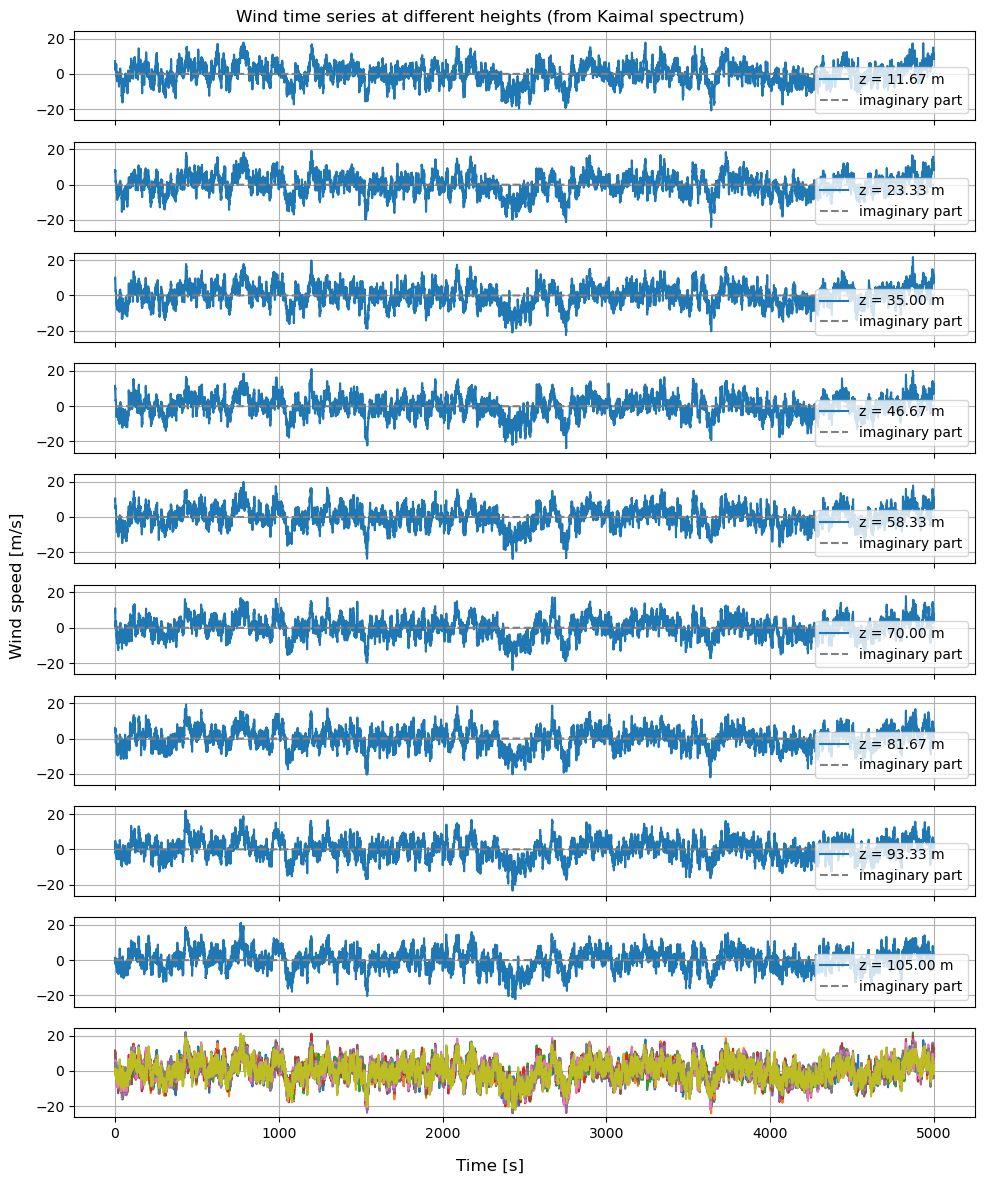

In [21]:
# Bart; attempt at question 4 kaimal spectrum
# not sure about the last step involving the ifft and the time vector. i think it is correct now just not sure about the amplitude scaling

N = len(f_kaimal)  # Number of frequency bins
df = f_kaimal[1] - f_kaimal[0]  # Frequency step size
fs = df * N # Frequency resolution


complex_fourier_coefficients_kaimal = np.zeros((len(z_nodes_air), len(f_kaimal)), dtype=complex)

# for every frequency
for i in range(N):
    R_n = R_N_wind_cross[:, :, i]
    S_n = S_wind_cross[:, :, i]
  
    random_phase = np.random.uniform(0, 2 * np.pi, size=len(S_n[0]))
    random_phase_vector = np.exp(1j * random_phase)
        
    H_n = np.linalg.cholesky(R_n)
    
    V_n = H_n @ random_phase_vector
    
    mask = np.eye(len(S_n))
    
    A_n = np.sqrt(2 * S_n * df) * mask
    
    X_n = A_n @ V_n
    
    complex_fourier_coefficients_kaimal[:, i] = X_n

dt = 1 / fs
time = np.arange(0, 2*N * dt+dt/2, dt)

fig, ax = plt.subplots(10, 1, figsize=(10, 12), sharex=True, sharey=True)
wind_turbulence = np.zeros((len(z_nodes_air), len(time)))

for i in range(len(z_nodes_air)):    
    X_complex = N * np.concatenate(([0+0j], complex_fourier_coefficients_kaimal[i], np.conjugate(complex_fourier_coefficients_kaimal[i][::-1])))
    time_series = np.fft.ifft(X_complex).real
    wind_turbulence[i] = time_series
    
    ax[i].plot(time, time_series.real, label=f'z = {z_nodes_air[i]:.2f} m')
    ax[i].plot(time, time_series.imag, color='gray', label=f'imaginary part', linestyle='--')
    ax[i].legend()
    ax[i].grid()
    
    ax[9].plot(time, time_series.real)

ax[9].grid()

fig.suptitle('Wind time series at different heights (from Kaimal spectrum)')
fig.supxlabel('Time [s]')
fig.supylabel('Wind speed [m/s]')
fig.tight_layout()

# Check the amplitude scaling of the generated turbulence time series

# The standard deviation of the turbulence at each height should match the theoretical value sigma_u
for i, z in enumerate(z_nodes_air):
    I_u = k * A_ / np.log(z / z_0)
    sigma_u_theory = I_u * U_bar(z, u_star, k, z_0)
    sigma_u_sim = np.std(wind_turbulence[i])
    print(f"z = {z:.2f} m: sigma_u (theory) = {sigma_u_theory:.2f}, sigma_u (sim) = {sigma_u_sim:.2f}")


In [22]:
def u_wave_particle(dzeta, f, d, z, x, t, amplitude=False):
    omega = 2 * np.pi * f
    k = solve_wavenumber(omega, g, d, k_guess=omega)
    G_z = np.cosh(k*(d+z)) / np.sinh(k*d)
    
    if amplitude:
        return dzeta * omega * G_z
    
    return dzeta * omega * G_z * np.cos(k*x - omega*t)

def w_wave_particle(dzeta, f, d, z, x, t, amplitude=False):
    omega = 2 * np.pi * f
    k = solve_wavenumber(omega, g, d, k_guess=omega)
    G_z = np.sinh(k*(d+z)) / np.sinh(k*d)
    if amplitude:
        return dzeta * omega * G_z
    
    return dzeta * omega * G_z * np.sin(k*x - omega*t) 

Wave height variance (LC1) from spectrum:    0.0226
Wave height variance (LC1) from time series: 0.0226

Wave velocity variance (LC1) from spectrum (z=0): 0.0838
Wave velocity variance (LC1) from time series (z=0): 0.0838

Wave height variance (LC2) from spectrum:    2.4313
Wave height variance (LC2) from time series: 2.4309

Wave velocity variance (LC2) from spectrum (z=0): 1.7074
Wave velocity variance (LC2) from time series (z=0): 1.7070


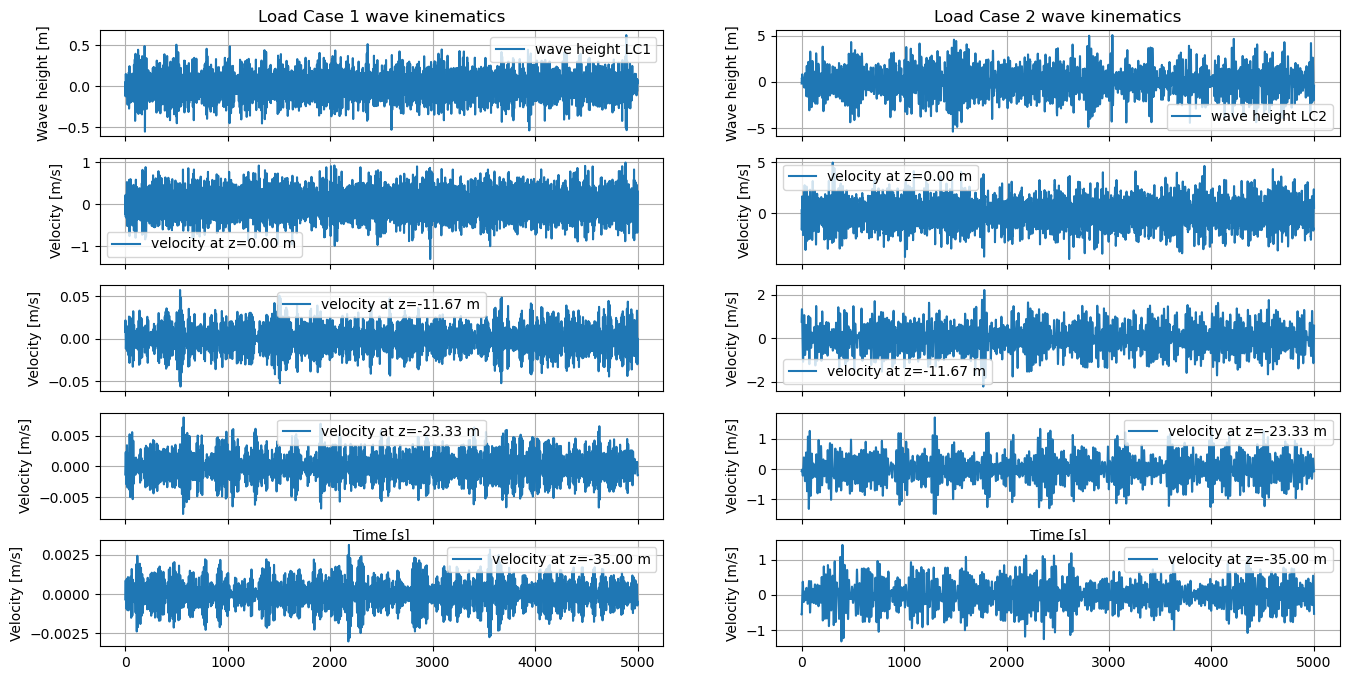

In [23]:
# Create spectra for velocities at different heights
z_nodes_water = z_nodes[z_nodes <= 0]
S_u_wave_LC1 = np.zeros((len(z_nodes_water), len(f_jonswap)))
S_w_wave_LC1 = np.zeros((len(z_nodes_water), len(f_jonswap)))
S_u_wave_LC2 = np.zeros((len(z_nodes_water), len(f_jonswap)))
S_w_wave_LC2 = np.zeros((len(z_nodes_water), len(f_jonswap)))

for i, z in enumerate(z_nodes_water):
    for j, f in enumerate(f_jonswap):
        transfer_function_u = u_wave_particle(1, f, h, z, 0, 0, amplitude=True)
        transfer_function_w = w_wave_particle(1, f, h, z, 0, 0, amplitude=True)
        
        S_u_wave_LC1[i, j] = transfer_function_u**2 * S_JS_1[j]
        S_w_wave_LC1[i, j] = transfer_function_w**2 * S_JS_1[j]
        S_u_wave_LC2[i, j] = transfer_function_u**2 * S_JS_2[j]
        S_w_wave_LC2[i, j] = transfer_function_w**2 * S_JS_2[j]   

# Create time series for wave heights for load cases 1 and 2
time, time_series_jonswap_LC1 = generate_time_series(S_JS_1, f_jonswap)
time, time_series_jonswap_LC2 = generate_time_series(S_JS_2, f_jonswap)

# Create time series for velocities at different heights for load cases 1 and 2
velocity_series_u_LC1 = np.zeros((len(z_nodes_water), len(time)))
velocity_series_u_LC2 = np.zeros((len(z_nodes_water), len(time)))
velocity_series_w_LC1 = np.zeros((len(z_nodes_water), len(time)))
velocity_series_w_LC2 = np.zeros((len(z_nodes_water), len(time)))

for i, z in enumerate(z_nodes_water):
    time, velocity_series_u_LC1[i] = generate_time_series(S_u_wave_LC1[i], f_jonswap)
    time, velocity_series_u_LC2[i] = generate_time_series(S_u_wave_LC2[i], f_jonswap)
    time, velocity_series_w_LC1[i] = generate_time_series(S_w_wave_LC1[i], f_jonswap)
    time, velocity_series_w_LC2[i] = generate_time_series(S_w_wave_LC2[i], f_jonswap)

# Plot the results
fig, ax = plt.subplots(5,2, figsize=(16, 8), sharex=True)

ax[0][0].plot(time, time_series_jonswap_LC1, label=f'wave height LC1')
ax[0][1].plot(time, time_series_jonswap_LC2, label=f'wave height LC2')

ax[1][0].plot(time, velocity_series_u_LC1[3], label=f'velocity at z={z_nodes_water[3]:.2f} m')
ax[1][1].plot(time, velocity_series_u_LC2[3], label=f'velocity at z={z_nodes_water[3]:.2f} m')

ax[2][0].plot(time, velocity_series_u_LC1[2], label=f'velocity at z={z_nodes_water[2]:.2f} m')
ax[2][1].plot(time, velocity_series_u_LC2[2], label=f'velocity at z={z_nodes_water[2]:.2f} m')

ax[3][0].plot(time, velocity_series_u_LC1[1], label=f'velocity at z={z_nodes_water[1]:.2f} m')
ax[3][1].plot(time, velocity_series_u_LC2[1], label=f'velocity at z={z_nodes_water[1]:.2f} m')

ax[4][0].plot(time, velocity_series_u_LC1[0], label=f'velocity at z={z_nodes_water[0]:.2f} m')
ax[4][1].plot(time, velocity_series_u_LC2[0], label=f'velocity at z={z_nodes_water[0]:.2f} m')

ax[0][0].set_title('Load Case 1 wave kinematics')
ax[0][1].set_title('Load Case 2 wave kinematics')

ax[0][0].set_ylabel('Wave height [m]')
ax[0][1].set_ylabel('Wave height [m]')

ax[1][0].set_ylabel('Velocity [m/s]')
ax[1][1].set_ylabel('Velocity [m/s]')

ax[2][0].set_ylabel('Velocity [m/s]')
ax[2][1].set_ylabel('Velocity [m/s]')

ax[3][0].set_ylabel('Velocity [m/s]')
ax[3][1].set_ylabel('Velocity [m/s]')

ax[4][0].set_ylabel('Velocity [m/s]')
ax[4][1].set_ylabel('Velocity [m/s]')

ax[3][0].set_xlabel('Time [s]')
ax[3][1].set_xlabel('Time [s]')

for i in range(5):
    for j in range(2):
        ax[i][j].grid()
        ax[i][j].legend()
        
        # Compute variance for wave height from spectrum (should be close to variance from time series)
variance_spectrum_LC1 = np.trapezoid(S_JS_1, f_jonswap)
variance_spectrum_LC2 = np.trapezoid(S_JS_2, f_jonswap)

variance_time_series_LC1 = np.var(time_series_jonswap_LC1)
variance_time_series_LC2 = np.var(time_series_jonswap_LC2)

print(f"Wave height variance (LC1) from spectrum:    {variance_spectrum_LC1:.4f}")
print(f"Wave height variance (LC1) from time series: {variance_time_series_LC1:.4f}")
print()
print(f"Wave velocity variance (LC1) from spectrum (z=0): {np.trapezoid(S_u_wave_LC1[3], f_jonswap):.4f}")
print(f"Wave velocity variance (LC1) from time series (z=0): {np.var(velocity_series_u_LC1[3]):.4f}")
print()
print(f"Wave height variance (LC2) from spectrum:    {variance_spectrum_LC2:.4f}")
print(f"Wave height variance (LC2) from time series: {variance_time_series_LC2:.4f}")
print()
print(f"Wave velocity variance (LC2) from spectrum (z=0): {np.trapezoid(S_u_wave_LC2[3], f_jonswap):.4f}")
print(f"Wave velocity variance (LC2) from time series (z=0): {np.var(velocity_series_u_LC2[3]):.4f}")
        

## Question 5 - Frequency domain analysis of linear system

To calculate the force spectrum, we need to define the q loads on all the nodes, based on the generated time series.

In [24]:
# Define force spectra due to waves
def alpha_wave(f, z, d, D):
    g = 9.81
    omega = 2 * np.pi * f
    k = solve_wavenumber(omega, g, d)
    G_z = np.cosh(k * (d + z)) / np.sinh(k * d)
    return np.pi/4* D**2 * 1000 * omega**2 * G_z

S_F_wave_LC1 = np.zeros((len(z_nodes_water), len(f_jonswap)))
S_F_wave_LC2 = np.zeros((len(z_nodes_water), len(f_jonswap)))

for i, z in enumerate(z_nodes_water):
    for j, f in enumerate(f_jonswap):
        S_F_wave_LC1[i, j] = (alpha_wave(f, z, h, d))**2 * S_JS_1[j]
        S_F_wave_LC2[i, j] = (alpha_wave(f, z, h, d))**2 * S_JS_2[j]

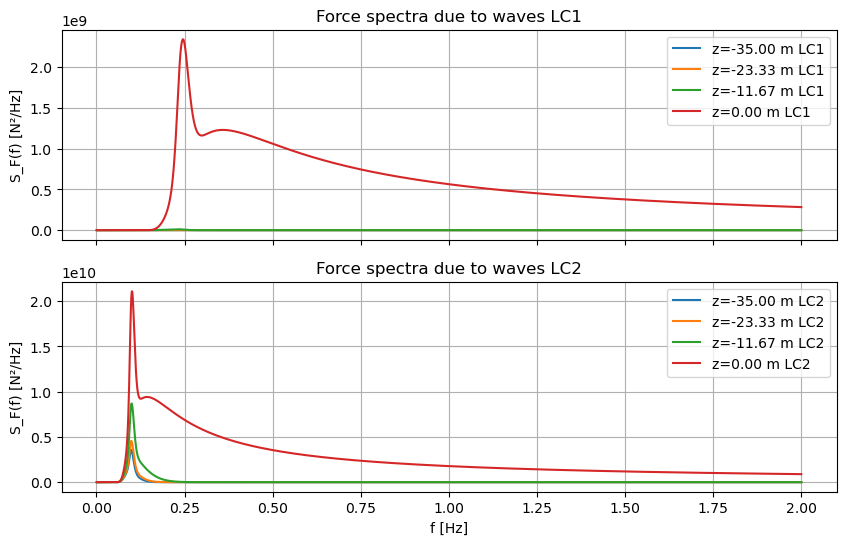

In [25]:
fig, ax = plt.subplots(2,1, figsize=(10, 6), sharex=True)
for i, z in enumerate(z_nodes_water):
    ax[0].plot(f_jonswap, S_F_wave_LC1[i], label=f'z={z:.2f} m LC1')
    ax[1].plot(f_jonswap, S_F_wave_LC2[i], label=f'z={z:.2f} m LC2')

ax[0].set_title('Force spectra due to waves LC1')
ax[1].set_title('Force spectra due to waves LC2')
ax[0].set_ylabel('S_F(f) [N²/Hz]')
ax[1].set_ylabel('S_F(f) [N²/Hz]')
ax[1].set_xlabel('f [Hz]')
ax[0].grid()
ax[1].grid()
ax[0].legend()
ax[1].legend();

Reynolds number = U_bar * D / viscosity_air = 65 * 7 / 1.813E-5 = 25096525 = 2.5E7 -> C_D = 0.6
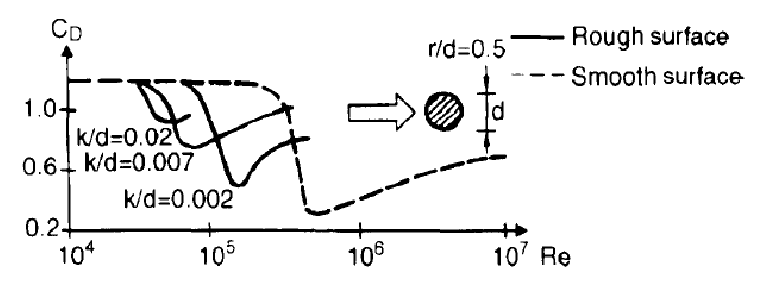

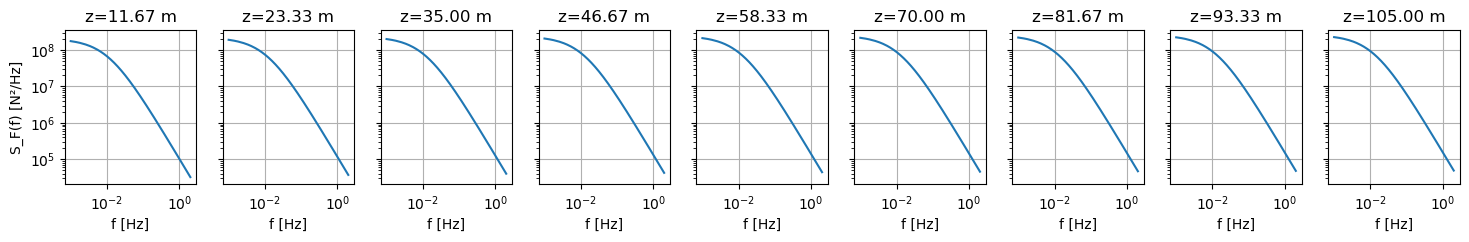

In [26]:
def alpha_wind(z, D):
    C_D = 0.6
    rho_air = 1.225  # Density of air [kg/m³]
    return rho_air * D * U_bar(z, u_star) * C_D

    
# Initialize full cross-spectral force matrix
S_F_wind = np.zeros((len(z_nodes_air), len(z_nodes_air), len(f_kaimal)))

# Fill in the cross-spectral force matrix
for i, z_i in enumerate(z_nodes_air):
    for k, z_k in enumerate(z_nodes_air):
        alpha_i = alpha_wind(z_i, d)
        alpha_k = alpha_wind(z_k, d)
        for j, f in enumerate(f_kaimal):
            S_F_wind[i, k, j] = alpha_i * alpha_k * S_wind_cross[i, k, j]
        
fig, ax = plt.subplots(1,9, figsize=(18,2), sharey=True)
for i, z in enumerate(z_nodes_air):
    ax[i].loglog(f_jonswap, S_F_wind[i,i], label=f'z={z:.2f} m LC1')
    ax[i].set_title(f'z={z:.2f} m')
    ax[i].set_xlabel('f [Hz]')
    ax[i].grid()
ax[0].set_ylabel('S_F(f) [N²/Hz]');

In [27]:
# calculate dynamic stiffness matrix
frequencies = f_kaimal

K_d = np.zeros((ndofs, ndofs, len(frequencies)), dtype=complex)

for i, f in enumerate(frequencies):
    omega = 2 * np.pi * f
    K_d[:,:,i] = K - omega**2 * M + 1j * omega * C_d

In [28]:
# define total force spectrum
S_F_total_LC1 = np.zeros((nn*2, nn*2, len(frequencies)))
S_F_total_LC2 = np.zeros((nn*2, nn*2, len(frequencies)))

for i in range(int(nn)):
    for j in range(int(nn)):
        if i < 4:
            if i == j:
                S_F_total_LC1[i*2, j*2] = S_F_wave_LC1[i]
                S_F_total_LC2[i*2, j*2] = S_F_wave_LC2[i]
        else:
            S_F_total_LC1[i*2, j*2] = S_F_wind[i-4, j-4]
            S_F_total_LC2[i*2, j*2] = S_F_wind[i-4, j-4]

In [29]:
SF_e_LC1 = 1/(rho*A) * M @ S_F_total_LC1
SF_e_LC2 = 1/(rho*A) * M @ S_F_total_LC2

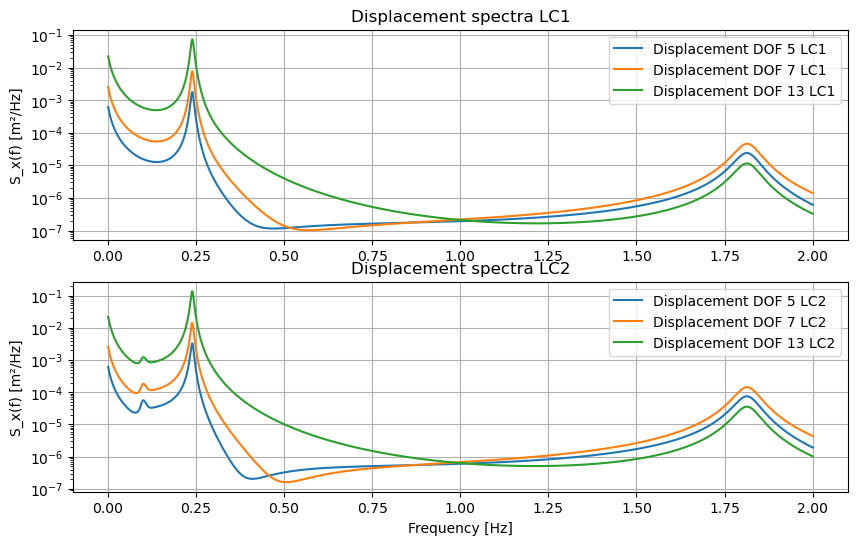

In [30]:
free_dofs = np.arange(2,ndofs)

Sx_LC1 = np.zeros((len(free_dofs), len(free_dofs), len(frequencies)), dtype=complex)
Sx_LC2 = np.zeros((len(free_dofs), len(free_dofs), len(frequencies)), dtype=complex)

# for every frequency
for i, f in enumerate(frequencies):
    omega = 2 * np.pi * f
    Kd_i = K_d[:,:,i]
    Kd_i_ff = Kd_i[np.ix_(free_dofs, free_dofs)]  # Extract the free DOFs part of the stiffness matrix
    
    # Calculate the force vector for the current frequency
    SF_e_LC1_i = SF_e_LC1[:,:, i]
    SF_e_LC2_i = SF_e_LC2[:,:, i]
    SF_e_LC1_i_ff = SF_e_LC1_i[np.ix_(free_dofs, free_dofs)]  # Extract the free DOFs part of the force vector
    SF_e_LC2_i_ff = SF_e_LC2_i[np.ix_(free_dofs, free_dofs)]  # Extract the free DOFs part of the force vector
    
    # Solve the system of equations
    Sx_LC1[:,:, i] = np.linalg.inv(Kd_i_ff) @ SF_e_LC1_i_ff @ np.conjugate(np.linalg.inv(Kd_i_ff))
    Sx_LC2[:,:, i] = np.linalg.inv(Kd_i_ff) @ SF_e_LC2_i_ff @ np.conjugate(np.linalg.inv(Kd_i_ff))

Sx_LC1_global = np.zeros((ndofs, ndofs, len(frequencies)), dtype=complex)
Sx_LC2_global = np.zeros((ndofs, ndofs, len(frequencies)), dtype=complex)

# Insert the results back into the global displacement vector
Sx_LC1_global[np.ix_(free_dofs, free_dofs)] = Sx_LC1
Sx_LC2_global[np.ix_(free_dofs, free_dofs)] = Sx_LC2

# Plot the results for three nodes
fig, ax = plt.subplots(2, 1, figsize=(10, 6))
for i in [3, 5, 11]:
    ax[0].semilogy(frequencies, np.abs(Sx_LC1[i*2, i*2]), label=f'Displacement DOF {free_dofs[i]} LC1')
    ax[1].semilogy(frequencies, np.abs(Sx_LC2[i*2, i*2]), label=f'Displacement DOF {free_dofs[i]} LC2')
    
ax[0].set_title('Displacement spectra LC1')
ax[1].set_title('Displacement spectra LC2')
ax[1].set_xlabel('Frequency [Hz]')
ax[0].set_ylabel('S_x(f) [m²/Hz]')
ax[1].set_ylabel('S_x(f) [m²/Hz]');
ax[0].legend()
ax[1].legend()
ax[0].grid()
ax[1].grid()

In [31]:
# compute moment at mudline
# moment at mudline is dependent on dofs of node 0 and 1.
S_M_mudline_LC1 = np.zeros(len(frequencies))
S_M_mudline_LC2 = np.zeros(len(frequencies))

for i, f in enumerate(frequencies):
    z_mud = 0.0
    elem_dofs = [0, 1, 2, 3]  # DOFs for the first element (node 0 and node 1)
    
    S_M_LC1_i = 0
    S_M_LC2_i = 0
    
    for j in range(4):
        for k in range(4):
            phi_j = E * I * ddN_k[j](z_mud)[0]
            phi_k = E * I * ddN_k[k](z_mud)[0]

            S_M_LC1_i += phi_j * phi_k * Sx_LC1_global[elem_dofs[j], elem_dofs[k], i]
            S_M_LC2_i += phi_j * phi_k * Sx_LC2_global[elem_dofs[j], elem_dofs[k], i]
    
    S_M_mudline_LC1[i] = S_M_LC1_i.real
    S_M_mudline_LC2[i] = S_M_LC2_i.real

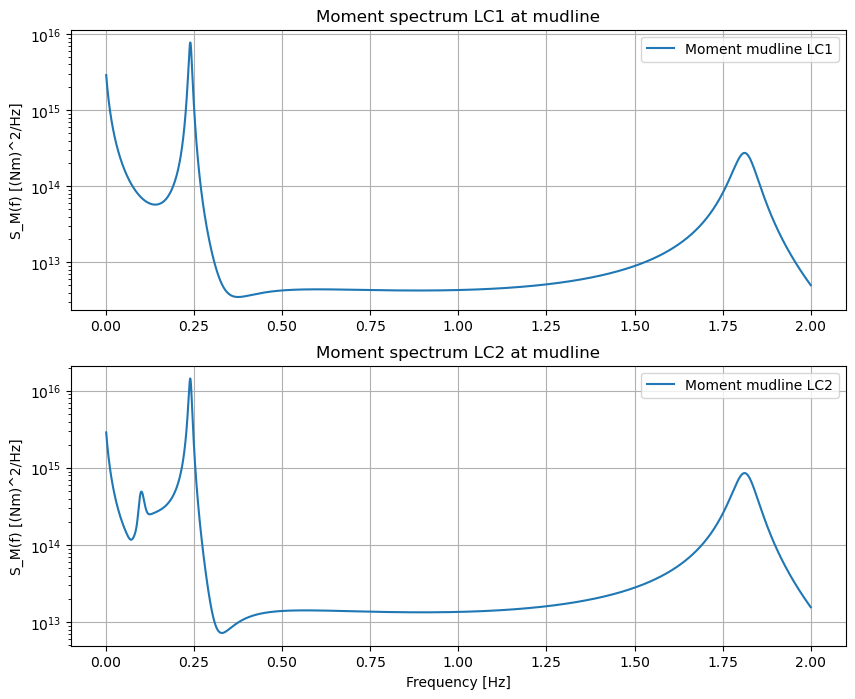

In [32]:
# Plot the results
fig, ax = plt.subplots(2, 1, figsize=(10, 8))

ax[0].semilogy(frequencies, S_M_mudline_LC1, label=f'Moment mudline LC1')
ax[1].semilogy(frequencies, S_M_mudline_LC2, label=f'Moment mudline LC2')
    
ax[0].set_title('Moment spectrum LC1 at mudline')
ax[1].set_title('Moment spectrum LC2 at mudline')
ax[1].set_xlabel('Frequency [Hz]')
ax[0].set_ylabel('S_M(f) [(Nm)^2/Hz]')
ax[1].set_ylabel('S_M(f) [(Nm)^2/Hz]')

ax[0].grid()
ax[1].grid()
ax[0].legend()
ax[1].legend();

## Question 6 - Time domain analysis of non-linear system

In [33]:
U_bar_vector = [U_bar(z, u_star, k, z_0) for z in z_nodes_air]

In [34]:
# compute time series for turbulence accelerations
velocity_LC1_dot = np.zeros((len(z_nodes_air), len(time)))
velocity_LC2_dot = np.zeros((len(z_nodes_air), len(time)))

for i, z in enumerate(z_nodes_water):
    velocity_LC1_dot[i] = np.gradient(velocity_series_u_LC1[i], time)
    velocity_LC2_dot[i] = np.gradient(velocity_series_u_LC2[i], time)

In [35]:
# Turn time series into functions of time with interpolation
from scipy.interpolate import interp1d
velocity_series_u_LC1_interp = [interp1d(time, velocity_series_u_LC1[i], kind='linear') for i in range(len(z_nodes_water))]
velocity_series_u_LC2_interp = [interp1d(time, velocity_series_u_LC2[i], kind='linear') for i in range(len(z_nodes_water))]

velocity_LC1_dot_interp = [interp1d(time, velocity_LC1_dot[i], kind='linear') for i in range(len(z_nodes_water))]
velocity_LC2_dot_interp = [interp1d(time, velocity_LC2_dot[i], kind='linear') for i in range(len(z_nodes_water))]

wind_turbulence_interp = [interp1d(time, wind_turbulence[i], kind='linear') for i in range(len(z_nodes_air))]

In [36]:
# use split wave signal function from lecture assignments
def split_wave_signal(w):
    zero_crossings = np.where(np.diff(np.signbit(w)))[0]

    Nw = len(zero_crossings) // 2 - 1 # number of waves
    T = np.zeros(Nw)
    H = np.zeros(Nw)

    for i in range(0, Nw):
        i_start = zero_crossings[2 * i]
        i_end = zero_crossings[2 * (i + 1)]
        T[i] = t[i_end] - t[i_start]
        H[i] = np.max(w[i_start:i_end]) - np.min(w[i_start:i_end])

    return T, H

def wave_velocity(T, H):
    g = 8.91
    omega = 2 * np.pi / T
    k = solve_wavenumber(omega, g, h)
    
    return H/2 * omega * np.cosh(k * h)/np.sinh(k * h)

In [37]:
# compute mean wave length, wave height and wave velocity for both load cases
w_vector = [time_series_jonswap_LC1, time_series_jonswap_LC2]
t = time

Hs_vector = []
T_mean_vector = []
Hmax_vector = []
U_mean_vector = []

for i, w in enumerate(w_vector):
    T, H = split_wave_signal(w)
    H_sorted = np.sort(H)
    H_length = len(H)
    
    # Reporting the results
    print(f"Time Series {i+1}: (N_periods = {T.size})")
    
    # Determine Significant wave height (Hs)
    Hs = np.mean(H_sorted[2*H_length//3:])
    Hs_vector.append(Hs)
    print(f"Significant wave height (Hs): {Hs:.2f} m")
    
    # Determine Mean wave period
    T_mean = np.mean(T)
    T_mean_vector.append(T_mean)
    print(f"Mean wave period (T_mean): {T_mean:.2f} s")
    
    # Determine max wave height (Hmax)
    Hmax = np.max(H)
    Hmax_vector.append(Hmax)
    print(f"Max wave height (Hmax): {Hmax:.2f} m")
    
    # Determine mean wave velocity
    u_vector = []
    for H, T in zip(H, T):
        u_vector.append(wave_velocity(T, H))
    U_mean = np.mean(u_vector)
    U_mean_vector.append(U_mean)    
    print(f"Mean wave velocity : {U_mean:.2f} m/s", end="\n\n")

Time Series 1: (N_periods = 749)
Significant wave height (Hs): 0.57 m
Mean wave period (T_mean): 6.67 s
Max wave height (Hmax): 1.13 m
Mean wave velocity : 0.17 m/s

Time Series 2: (N_periods = 325)
Significant wave height (Hs): 5.91 m
Mean wave period (T_mean): 15.34 s
Max wave height (Hmax): 9.31 m
Mean wave velocity : 1.06 m/s



In [38]:
# compute wave averaged KC values
for i in range(2):
    print(f"Wave averaged KC value for time series {i+1}: {U_mean_vector[i] * T_mean_vector[i] / d:.2f}")

Wave averaged KC value for time series 1: 0.16
Wave averaged KC value for time series 2: 2.32


The KC number for LC1 is smaller than 3 which means that the inertia term is dominant and the drag term can be assumed to be zero.

The KC number for LC2 is smaller than 3 which means that the inertia term is dominant and the drag term can be assumed to be zero.

However, the time integration method gives the possibility to include nonlinear terms relatively easily, as long as they do not depend on the acceleration.

In [39]:
# compute non linear wave and wind forces
def F_wind(U_bar, u, x_dot):
    rho_air = 1.225  # Density of air [kg/m³]
    C_D = 0.6  # Drag coefficient
    return 0.5 * rho_air * C_D * (U_bar + u - x_dot)**2

def F_wave(u, u_dot, x_dot):
    rho_water = 1000
    C_D = 0.6
    
    # intertia force
    f_I = 0.25 * rho_water * np.pi * d**2 * 2.0 * u_dot
    
    # drag force
    f_D = 0.5 * rho_water * d * C_D * abs(u - x_dot) * (u - x_dot)
    return f_I + f_D

def F_total(t, u_wind, u_wave, u_wave_dot, x_dot):
    
    F_vector = np.zeros(nn*2)
    for i in range(int(nn/2)):
        if i < 4:
            F_vector[i*2] = F_wave(u_wave[i](t), u_wave_dot[i](t), x_dot[i*2])
        else:
            F_vector[i*2] = F_wind(U_bar_vector[i-4], u_wind[i-4](t), x_dot[i*2])
            
    return F_vector

In [40]:
# include relative kinematics in mass matrix
rho_water = 1000  # Density of water [kg/m³]

# Add extra mass contribution due to wave kinematics
M_mod = M.copy()
M_mod[0:8:2, 0:8:2] += np.diag(np.ones(4) * 0.25 * np.pi * d**2 * rho_water)

# Reduce matrices to free DOFs
M_mod_r = M_mod[np.ix_(free_dofs, free_dofs)]
K_r = K[np.ix_(free_dofs, free_dofs)]
C_d_r = C_d[np.ix_(free_dofs, free_dofs)]

# Precompute inverse of reduced mass matrix
inv_M_mod_r = np.linalg.inv(M_mod_r)

In [41]:
# solve the time domain analysis for load case 1
def system_LC1(t, y):
    x = y[:len(free_dofs)]
    x_dot = y[len(free_dofs):]
    
    f_D = F_total(t, wind_turbulence_interp, velocity_series_u_LC1_interp, velocity_LC1_dot_interp, x_dot)
    f_D_e = 1/(rho*A) * M_mod @ f_D
    f_D_e_r = f_D_e[free_dofs]
    
    dxdt = x_dot
    dx_dotdt = inv_M_mod_r @ (-K_r @ x - C_d_r @ x_dot + f_D_e_r)
    
    return np.concatenate((dxdt, dx_dotdt))

# Initial conditions
y0 = np.zeros(len(free_dofs)*2)  # Initial displacements and velocities
t0 = 0
t_end = 500  # End time for the simulation
time_eval = np.linspace(t0, t_end, 5000)  # Time vector for the simulation

sol1 = scipy.integrate.solve_ivp(system_LC1, [t0, t_end], y0, t_eval=time_eval, method='BDF')

In [42]:
# solve the time domain analysis for load case 2
def system_LC2(t, y):
    x = y[:len(free_dofs)]
    x_dot = y[len(free_dofs):]
    
    f_D = F_total(t, wind_turbulence_interp, velocity_series_u_LC2_interp, velocity_LC2_dot_interp, x_dot)
    f_D_e = 1/(rho*A) * M_mod @ f_D
    f_D_e_r = f_D_e[free_dofs]
    
    dxdt = x_dot
    dx_dotdt = inv_M_mod_r @ (-K_r @ x - C_d_r @ x_dot + f_D_e_r)
    
    return np.concatenate((dxdt, dx_dotdt))

# Initial conditions
y0 = np.zeros(len(free_dofs)*2)  # Initial displacements and velocities
t0 = 0
t_end = 500  # End time for the simulation
time_eval = np.linspace(t0, t_end, 5000)  # Time vector for the simulation

sol2 = scipy.integrate.solve_ivp(system_LC2, [t0, t_end], y0, t_eval=time_eval, method='BDF')

In [43]:
# Insert the results back into a global displacement vector
x_LC1_global = np.zeros((ndofs, len(time_eval)))
x_LC2_global = np.zeros((ndofs, len(time_eval)))

x_LC1_global[free_dofs, :] = sol1.y[:len(free_dofs)]
x_LC2_global[free_dofs, :] = sol2.y[:len(free_dofs)]

In [44]:
# compute moment at mudline
# moment at mudline is dependent on dofs of node 0 and 1.
M_mudline_LC1 = np.zeros(len(time_eval))
M_mudline_LC2 = np.zeros(len(time_eval))

for i, t in enumerate(time_eval):
    # local z coordinate at mudline
    z_mud = 0.0
    
    # indices of the dofs that contribute to the moment at the mudline
    elem_dofs = np.array([0,1,2,3])
    
    M_LC1_i = 0
    M_LC2_i = 0
    
    # loop over the dofs of the first element
    for j in range(4):
        M_LC1_i += (-E*I * ddN_k[j](z_mud) * x_LC1_global[elem_dofs[j], i])[0]
        M_LC2_i += (-E*I * ddN_k[j](z_mud) * x_LC2_global[elem_dofs[j], i])[0]
    
    M_mudline_LC1[i] = M_LC1_i
    M_mudline_LC2[i] = M_LC2_i

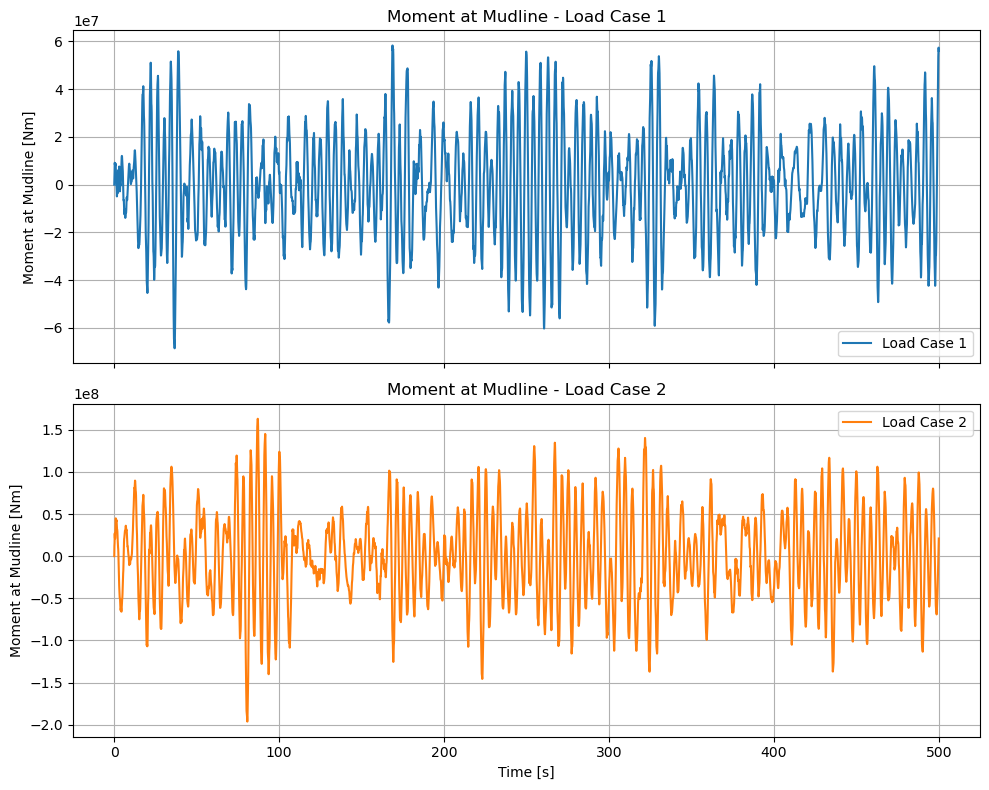

In [45]:
fig, ax = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

ax[0].plot(time_eval, M_mudline_LC1, label='Load Case 1')
ax[0].set_ylabel('Moment at Mudline [Nm]')
ax[0].set_title('Moment at Mudline - Load Case 1')
ax[0].grid()
ax[0].legend()

ax[1].plot(time_eval, M_mudline_LC2, label='Load Case 2', color='tab:orange')
ax[1].set_xlabel('Time [s]')
ax[1].set_ylabel('Moment at Mudline [Nm]')
ax[1].set_title('Moment at Mudline - Load Case 2')
ax[1].grid()
ax[1].legend()

plt.tight_layout()

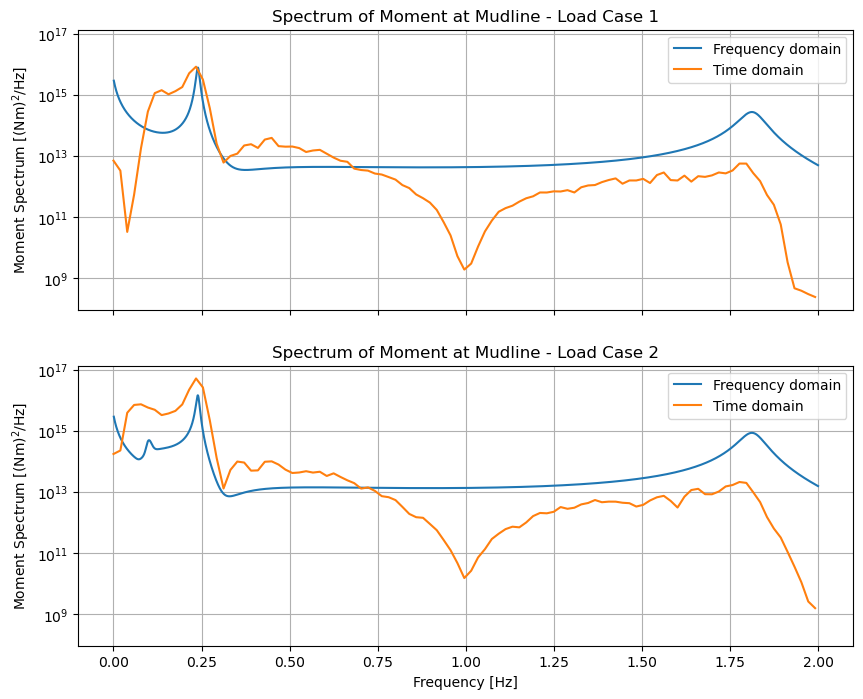

In [46]:
from scipy.signal import welch

# The moment at the mudline time series for both load cases

# Use Welch's method to estimate the power spectral density
fs = 1 / (time_eval[1] - time_eval[0])  # Sampling frequency from time vector

f_max_plot = 2.0

f_mudline_LC1, S_M_mudline_LC1_ts = welch(M_mudline_LC1, fs=fs, nperseg=512)
f_mudline_LC2, S_M_mudline_LC2_ts = welch(M_mudline_LC2, fs=fs, nperseg=512)

# Plot the spectra
fig, ax = plt.subplots(2,1, figsize=(10, 8), sharex=True, sharey=True)

ax[0].semilogy(frequencies, S_M_mudline_LC1, label=f'Frequency domain')
ax[1].semilogy(frequencies, S_M_mudline_LC2, label=f'Frequency domain')
ax[0].semilogy(f_mudline_LC1[f_mudline_LC1 < f_max_plot], S_M_mudline_LC1_ts[f_mudline_LC1 < f_max_plot], label='Time domain')
ax[1].semilogy(f_mudline_LC2[f_mudline_LC1 < f_max_plot], S_M_mudline_LC2_ts[f_mudline_LC1 < f_max_plot], label='Time domain')

ax[1].set_xlabel('Frequency [Hz]')
ax[0].set_ylabel('Moment Spectrum [(Nm)$^2$/Hz]')
ax[1].set_ylabel('Moment Spectrum [(Nm)$^2$/Hz]')
ax[0].set_title('Spectrum of Moment at Mudline - Load Case 1')
ax[1].set_title('Spectrum of Moment at Mudline - Load Case 2')
ax[0].grid()
ax[1].grid()
ax[0].legend()
ax[1].legend();

In [47]:
# # Code for creating animations of the wind turbine displacement over time
# from matplotlib.animation import FuncAnimation
# from IPython.display import HTML

# # Animation for Load Case 1 (sol1)
# fig1, ax1 = plt.subplots(figsize=(8, 5))
# line1, = ax1.plot([], [], marker='o')
# ax1.set_xlim(np.min(sol1.y[::2, :]), np.max(sol1.y[::2, :]))
# ax1.set_ylim(np.min(xn), np.max(xn))
# ax1.set_xlabel('Displacement [m]')
# ax1.set_ylabel('Height [m]')
# ax1.set_title('Wind Turbine Displacement Animation (Load Case 1)')
# ax1.grid()

# def init1():
#     line1.set_data([], [])
#     return line1,

# def update1(frame):
#     displacement = np.zeros(nn)
#     for i in range(nn-1):
#         displacement[i+1] = sol1.y[i*2, frame]
#     line1.set_data(displacement, xn)
#     ax1.set_title(f'Wind Turbine Displacement at t = {sol1.t[frame]:.2f} s (LC1)')
#     return line1,

# ani1 = FuncAnimation(fig1, update1, frames=sol1.y.shape[1], init_func=init1, blit=True, interval=100)

# # display(HTML(ani1.to_jshtml()))

# # Animation for Load Case 2 (sol2)
# fig2, ax2 = plt.subplots(figsize=(8, 5))
# line2, = ax2.plot([], [], marker='o')
# ax2.set_xlim(np.min(sol2.y[::2, :]), np.max(sol2.y[::2, :]))
# ax2.set_ylim(np.min(xn), np.max(xn))
# ax2.set_xlabel('Displacement [m]')
# ax2.set_ylabel('Height [m]')
# ax2.set_title('Wind Turbine Displacement Animation (Load Case 2)')
# ax2.grid()

# def init2():
#     line2.set_data([], [])
#     return line2,

# def update2(frame):
#     displacement = np.zeros(nn)
#     for i in range(nn-1):
#         displacement[i+1] = sol2.y[i*2, frame]
#     line2.set_data(displacement, xn)
#     ax2.set_title(f'Wind Turbine Displacement at t = {sol2.t[frame]:.2f} s (LC2)')
#     return line2,

# ani2 = FuncAnimation(fig2, update2, frames=sol2.y.shape[1], init_func=init2, blit=True, interval=100)

# # display(HTML(ani2.to_jshtml()))

# # Save animations as mp4 video and gif
# ani1.save('wind_turbine_displacement_LC1.gif', writer='pillow', fps=10)
# ani2.save('wind_turbine_displacement_LC2.gif', writer='pillow', fps=10)


## Question 7 - Compare frequency domain analysis and time domain analysis

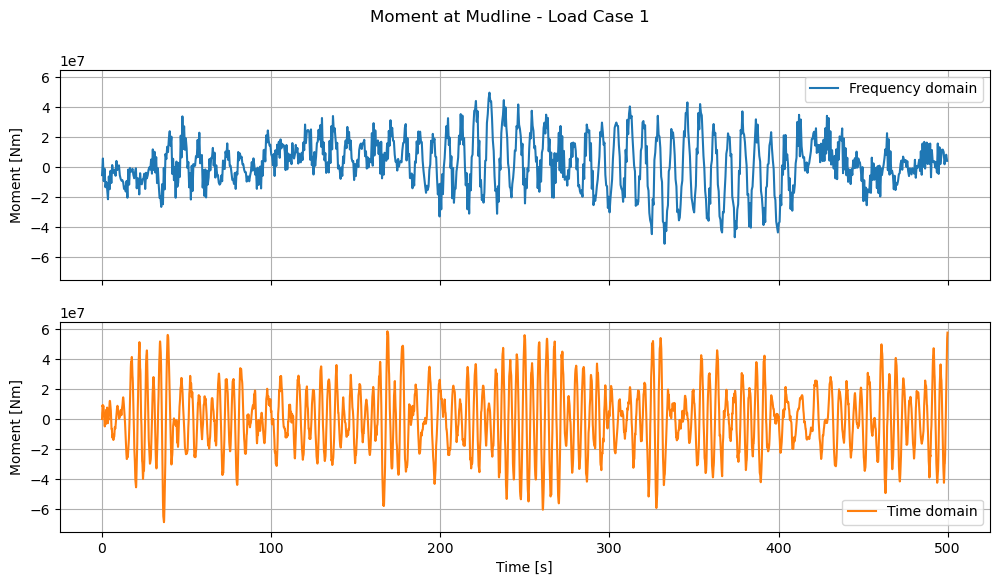

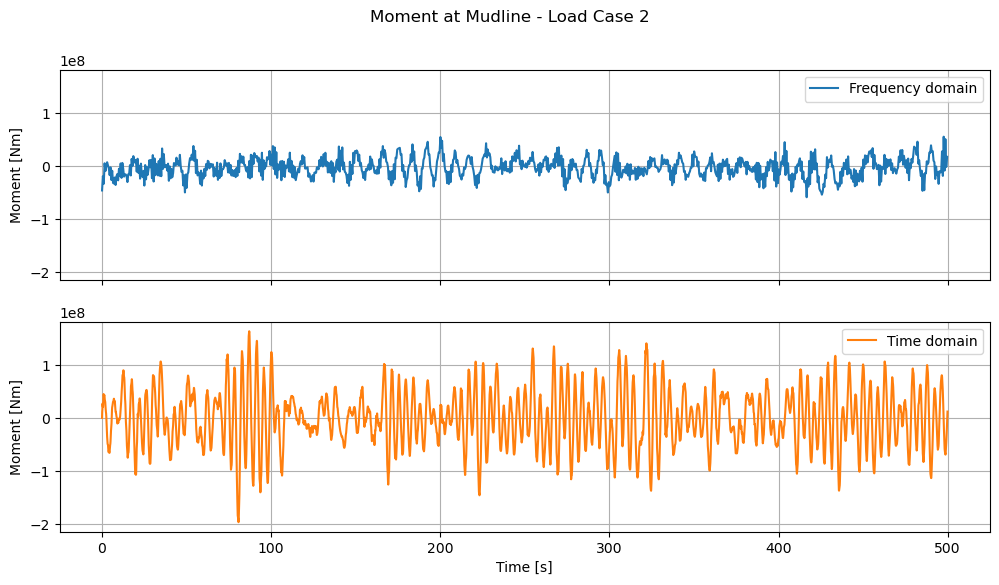

In [48]:
# compute the time series of the moment at the mudline from the frequency domain spectrum
time, M_mudline_fd_LC1 = generate_time_series(S_M_mudline_LC1, frequencies)
time, M_mudline_fd_LC2 = generate_time_series(S_M_mudline_LC2, frequencies)

t_max_plot = 500  # Maximum time for plotting

# Plot the moment time series for frequency domain and time domain.
fig, ax = plt.subplots(2,1, figsize=(12, 6), sharex=True, sharey=True)
fig.suptitle('Moment at Mudline - Load Case 1')
ax[0].plot(time[time < t_max_plot], M_mudline_fd_LC1[time < t_max_plot], label='Frequency domain')
ax[1].plot(time_eval[time_eval < t_max_plot], M_mudline_LC1[time_eval < t_max_plot], 'tab:orange', label='Time domain')
ax[0].set_ylabel('Moment [Nm]')
ax[1].set_ylabel('Moment [Nm]')
ax[1].set_xlabel('Time [s]')
ax[0].grid()
ax[1].grid()
ax[0].legend()
ax[1].legend()

fig, ax = plt.subplots(2,1, figsize=(12, 6), sharex=True, sharey=True)
fig.suptitle('Moment at Mudline - Load Case 2')
ax[0].plot(time[time < t_max_plot], M_mudline_fd_LC2[time < t_max_plot], label='Frequency domain')
ax[1].plot(time_eval[time_eval < t_max_plot], M_mudline_LC2[time_eval < t_max_plot], 'tab:orange', label='Time domain')
ax[0].set_ylabel('Moment [Nm]')
ax[1].set_ylabel('Moment [Nm]')
ax[1].set_xlabel('Time [s]')
ax[0].grid()
ax[1].grid()
ax[0].legend()
ax[1].legend();

In [49]:
# Compute variance for both load cases and both methods

# Frequency domain (from spectrum)
variance_fd_LC1 = np.trapezoid(S_M_mudline_LC1, frequencies)
variance_fd_LC2 = np.trapezoid(S_M_mudline_LC2, frequencies)

# Time domain (from time series)
variance_td_LC1 = np.trapezoid(S_M_mudline_LC1_ts, f_mudline_LC1)
variance_td_LC2 = np.trapezoid(S_M_mudline_LC2_ts, f_mudline_LC2)

print("Standard deviations calculated from the spectra:")
print("======================================================")

print(f"Standard Deviation (Frequency domain, LC1): {np.sqrt(variance_fd_LC1)/1000:.0f} kNm")
print(f"Standard Deviation (Time domain, LC1):      {np.sqrt(variance_td_LC1)/1000:.0f} kNm")
print(f"Standard Deviation (Frequency domain, LC2): {np.sqrt(variance_fd_LC2)/1000:.0f} kNm")
print(f"Standard Deviation (Time domain, LC2):      {np.sqrt(variance_td_LC2)/1000:.0f} kNm")

print()

print("Standard deviations calculated from the time series:")
print("======================================================")

print(f"Standard Deviation (Frequency domain, LC1): {np.std(M_mudline_fd_LC1)/1000:.0f} kNm")
print(f"Standard Deviation (Time domain, LC1):      {np.std(M_mudline_LC1)/1000:.0f} kNm")
print(f"Standard Deviation (Frequency domain, LC2): {np.std(M_mudline_fd_LC2)/1000:.0f} kNm")
print(f"Standard Deviation (Time domain, LC2):      {np.std(M_mudline_LC2)/1000:.0f} kNm")

print()

# Compute mean crossing period Tz for both load cases (time domain)

def compute_Tz(signal, t):
    # Find zero up-crossings
    crossings = np.where((signal[:-1] < 0) & (signal[1:] >= 0))[0]
    if len(crossings) < 2:
        return np.nan  # Not enough crossings to compute period
    T = np.diff(t[crossings])
    return np.mean(T)

Tz_fd_LC1 = compute_Tz(M_mudline_fd_LC1, time)
Tz_fd_LC2 = compute_Tz(M_mudline_fd_LC2, time)

Tz_td_LC1 = compute_Tz(M_mudline_LC1, time_eval)
Tz_td_LC2 = compute_Tz(M_mudline_LC2, time_eval)

print("Mean crossing periods calculated from the time series:")
print("======================================================")
print(f"Tz (Frequency domain, LC1):                 {Tz_fd_LC1:.2f} s")
print(f"Tz (Time domain, LC1):                      {Tz_td_LC1:.2f} s")

print(f"Tz (Frequency domain, LC2):                 {Tz_fd_LC2:.2f} s")
print(f"Tz (Time domain, LC2):                      {Tz_td_LC2:.2f} s")

print()

print("Maximum moment at mudline calculated from the time series:")
print("=======================================================")
print(f"M_max (Frequency domain, LC1):              {np.max(np.abs(M_mudline_fd_LC1))/1000:.0f} kNm")
print(f"M_max (Time domain, LC1):                   {np.max(np.abs(M_mudline_LC1))/1000:.0f} kNm")
print(f"M_max (Frequency domain, LC2):              {np.max(np.abs(M_mudline_fd_LC2))/1000:.0f} kNm")
print(f"M_max (Time domain, LC2):                   {np.max(np.abs(M_mudline_LC2))/1000:.0f} kNm")

Standard deviations calculated from the spectra:
Standard Deviation (Frequency domain, LC1): 13639 kNm
Standard Deviation (Time domain, LC1):      21832 kNm
Standard Deviation (Frequency domain, LC2): 19856 kNm
Standard Deviation (Time domain, LC2):      54471 kNm

Standard deviations calculated from the time series:
Standard Deviation (Frequency domain, LC1): 13659 kNm
Standard Deviation (Time domain, LC1):      21637 kNm
Standard Deviation (Frequency domain, LC2): 19868 kNm
Standard Deviation (Time domain, LC2):      53908 kNm

Mean crossing periods calculated from the time series:
Tz (Frequency domain, LC1):                 3.59 s
Tz (Time domain, LC1):                      4.36 s
Tz (Frequency domain, LC2):                 2.90 s
Tz (Time domain, LC2):                      4.84 s

Maximum moment at mudline calculated from the time series:
M_max (Frequency domain, LC1):              55021 kNm
M_max (Time domain, LC1):                   68559 kNm
M_max (Frequency domain, LC2):       

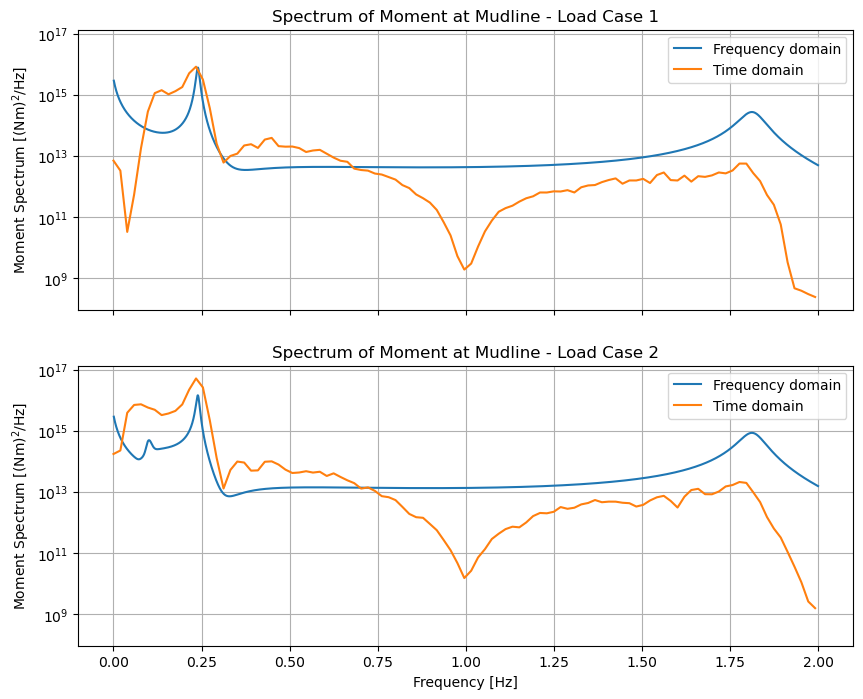

In [50]:
f_max_plot = 2.0

f_mudline_LC1, S_M_mudline_LC1_ts = welch(M_mudline_LC1, fs=fs, nperseg=512)
f_mudline_LC2, S_M_mudline_LC2_ts = welch(M_mudline_LC2, fs=fs, nperseg=512)

# Plot the spectra
fig, ax = plt.subplots(2,1, figsize=(10, 8), sharex=True, sharey=True)

ax[0].semilogy(frequencies, S_M_mudline_LC1, label=f'Frequency domain')
ax[1].semilogy(frequencies, S_M_mudline_LC2, label=f'Frequency domain')
ax[0].semilogy(f_mudline_LC1[f_mudline_LC1 < f_max_plot], S_M_mudline_LC1_ts[f_mudline_LC1 < f_max_plot], label='Time domain')
ax[1].semilogy(f_mudline_LC2[f_mudline_LC1 < f_max_plot], S_M_mudline_LC2_ts[f_mudline_LC1 < f_max_plot], label='Time domain')

ax[1].set_xlabel('Frequency [Hz]')
ax[0].set_ylabel('Moment Spectrum [(Nm)$^2$/Hz]')
ax[1].set_ylabel('Moment Spectrum [(Nm)$^2$/Hz]')
ax[0].set_title('Spectrum of Moment at Mudline - Load Case 1')
ax[1].set_title('Spectrum of Moment at Mudline - Load Case 2')
ax[0].grid()
ax[1].grid()
ax[0].legend()
ax[1].legend();

In the 2 code cells above, the standard deviations, mean crossing period and maxima are computed. Also the moment spectra are plotted for both the frequency domain analysis and the time domain analysis.

**Observations:**

The following differences between the frequency domain analysis and time domain analysis can be observed:
- Time domain contains more energy at low frequencies and less energy at high frequenies than the frequency domain.
- The second mode of the system is a lot more pronounced in the frequency domain than in the time domain.
- The time domain spectrum shows a very clear dip at a freqeuncy of 1 Hz which is not present in the frequency domain.
- The standard deviations for the time domain are higher than those for the frequency domain.
- The mean crossing periods for the time domain are longer than those for the frequency domain.
- The maxima for the time domain are higher than those for the frequency domain.

The following similarities between the frequency domain analysis and time domain analysis can be observed:
- Both methods have a clear peak at a frequency of 0.24 Hz which corresponds to the first natural frequency.
- Both methods compute a lot of energy at frequencies lower than 0.25 Hz for load case 2.
- The second natural frequency of 1.81 Hz is recognizable in the spectrum for both methods.

**Conclusions:**
1. **Amount of energy.**
   
There is a clear difference in amount of energy between the two methods. This can be explained by the effect of relative kinematics that is included in the time domain, and not in the frequency domain. This effect results in extra forcing which in turn results in more energy in the system.

This also explains the difference in standard deviation and the difference in maxima between the two methods.

2. **Difference in mean crossing period.**

The mean crossing period computed from the frequency domain analysis is significantly shorter than the mean crossing period computed from the time domain analysis. This can also be explained by the relative kinematics. Both the wave and wind loads contain a term that is proportional to x_dot. These terms effectively increase the amount of damping in the system. Higher damping reduces the significance of higher modes and smooths out the time series. The absence of these high frequencies (and thus a short wave period) results in an increase of the mean wave period for time domain analysis.

3. **The dip in frequency at 1 Hz.**

The dip in energy at 1 Hz is likely caused by an anti resonance caused by the relative kinematics. At 1 Hz it is likely that the forcing caused by the wind and/or waves results in movement of the structure that cause the same force but in the opposite direction. When this happens the effective forcing is close to zero, which explains the sharp dip in the spectrum.

4. **Similarities.**

The observed similarities hint on a succesful analysis. Both methods of analysis have similar spectra which is expected because the same structure is analyzed with the same loading.

5. **Difference between the load cases.**

In question 3, the spectra of the wind turbulence and wave heights are computed. The wave heights have two different load cases. The first load case has its peak at 0.25 Hz, the second load case has its peak at 0.1 Hz and a lot more energy. The properties of the loading should be recognizable in the results.

- Both load cases have the same wind cross spectrum. The wind cross spectrum contains a lot of energy at low frequencies which can be observed in both the time domain and frequency domain results.

- The peak at 0.1 Hz of the second load case can clearly be observed in the frequency domain. In the time domain the peak is less clear, but it is obvious that there is a lot of energy present at low frequencies (more than for load case 1).

6. **Magnitude.**

The maximum moment at the mudline for load case 2 in the time domain is 170960 kNm. To check if the magnitude of this moment is plausible, the distributed load that is needed in a static situation to get the same moment at the mudline is: 2 * 170960 / 140^2 = 17.5 kN/m. When comparing this to the weight of the wind turbine itself which is: rho * A * g = 118.5 kN/m. This is about a factor 7 higher. It is therefore concluded that the maximum moment computed is plausible.



# Question 8

To assess the assumptions regarding diffraction, a comparison is made between the wave force from diffraction theory and the wave force from morrison equation for both load cases.

In [51]:
from scipy.special import jvp, yvp

rho_water = 1000
g = 9.81
D = 7
a = D/2

# Use significant wave heights and mean periods from the previous calculations
A1 = Hs_vector[0]
f1 = 1/T_mean_vector[0]

A2 = Hs_vector[1]
f2 = 1/T_mean_vector[1]

# Fromulas for diffraction and Morison force calculations
def A(x):
    return np.pi/2 * x**2

def alpha(x):
    return np.pi/4 * x**2

def F_H_diff(zeta, f, d, z):
    omega = 2 * np.pi * f
    k = omega**2 / g
    return 4 * rho_water * zeta * g/k * np.cosh(k*(d+z))/np.cosh(k*d) * 1 / (np.sqrt(jvp(1,k*a)**2 + yvp(1,k*a)**2))

def F_H_morr(zeta, f, d, z):
    omega = 2 * np.pi * f
    k = omega**2 / g
    G_z = np.cosh(k*(d+z)) / np.sinh(k*d)
    u_dot = zeta * omega**2 * G_z
    return 1/4 * np.pi * D**2 * 2 * rho_water * u_dot

# Calculate the forces 1 meter below the surface (z = -1 m)
F_H_1 = F_H_diff(A1, f1, h, -1)
F_H_2 = F_H_diff(A2, f2, h, -1)

F_H_1_morr = F_H_morr(A1, f1, h, -1)
F_H_2_morr = F_H_morr(A2, f2, h, -1)

In [52]:
#  Print the results
print(f"Wave forces at z=-1 m for load case 1 and 2:")
print("=================================================")
print(f"Wave force from diffraction theory (LC1): {F_H_1/1000:.1f}  kN")
print(f"Wave force from morrison equation (LC1):  {F_H_1_morr/1000:.1f}  kN")
print()
print(f"Wave force from diffraction theory (LC2): {F_H_2/1000:.1f}  kN")
print(f"Wave force from morrison equation (LC2):  {F_H_2_morr/1000:.1f} kN")

Wave forces at z=-1 m for load case 1 and 2:
Wave force from diffraction theory (LC1): 37.1  kN
Wave force from morrison equation (LC1):  36.0  kN

Wave force from diffraction theory (LC2): 76.0  kN
Wave force from morrison equation (LC2):  141.2 kN


This quick calculation shows that the morrison equation and diffraction theory agree for load case 1, however for load case 2 the diffraction theory computes a force that is half of the morrison equation. Therefore the analysis for load case 2 should be repeated with diffraction theory to obtain a more accurate result.